In [1]:
import os
if os.name != 'posix':
    %matplotlib ipympl
else:
    %matplotlib notebook
import scipy.constants as sc
from scipy.optimize import fsolve

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
import h5py

print(os.getpid())
%cd ../../

import pylib.mix as mix
import pylib.measurement as mse

32500
/media/work/docs/codes/QuCF/scripts-py


In [2]:
# --- Launch to change cells' width ---
import cvxpy as cp

# from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

import pylib.qsvt_angles as qsvt_a

colors_ = ["blue", "red", "green", "gray", "black"]

from matplotlib import ticker
cmap_two_signs_= 'coolwarm'
cmap_two_signs_= 'Blues'
# cmap_two_signs_= 'Greys'
# cmap_two_signs_= 'Pastel1'
# cmap_two_signs_= 'flag'
# cmap_two_signs_= 'nipy_spectral'
# cmap_two_signs_= 'jet'
# cmap_two_signs_= 'seismic'
def fmt_(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

for i in range(10):
    plt.close()

In [3]:
# --- Global parameters ---
path_coef_ = "../QuCF/tests/compute-angles/inversion"
# filenames_ = [
#     "k20_eps4.hdf5", "k20_eps5.hdf5", 
#     "k20_eps6.hdf5", "k20_eps7.hdf5", 
#     "k20_eps8.hdf5", "k20_eps12.hdf5"
# ]
# filenames_ = ["k20_eps12.hdf5", "k20_eps4.hdf5"]
# filenames_ = ["k10_eps12.hdf5", "k20_eps12.hdf5"]
# filenames_ = ["k10_eps4.hdf5", "k20_eps4.hdf5", "k40_eps4.hdf5"]

filenames_ = ["k10_eps4.hdf5", "k20_eps4.hdf5", "k40_eps4.hdf5"]

In [4]:
# -----------------------------------------
# --- Read data ----
# -----------------------------------------
mix.reload_module(qsvt_a)
dds_ = []
for ii in range(len(filenames_)):
    print("\n----------------------------------------")
    dds_.append(qsvt_a.read_angles(path_coef_, filenames_[ii]))
del ii


----------------------------------------
Reading angles from the file 
../QuCF/tests/compute-angles/inversion/k10_eps4.hdf5
when simulated:  12-07-2023 14:10:11

function-type: 		inversion
function-parity: 		1
param: 			10.000000
absolute error: 	1.189e-04
norm. factor: 		1.250e-01
Number of angles: 	230

----------------------------------------
Reading angles from the file 
../QuCF/tests/compute-angles/inversion/k20_eps4.hdf5
when simulated:  12-07-2023 13:27:06

function-type: 		inversion
function-parity: 		1
param: 			20.000000
absolute error: 	1.657e-04
norm. factor: 		1.250e-01
Number of angles: 	450

----------------------------------------
Reading angles from the file 
../QuCF/tests/compute-angles/inversion/k40_eps4.hdf5
when simulated:  12-07-2023 14:14:01

function-type: 		inversion
function-parity: 		1
param: 			40.000000
absolute error: 	1.657e-04
norm. factor: 		1.250e-01
Number of angles: 	900


In [5]:
# -----------------------------------------
# --- Features ----
# -----------------------------------------
def extract_env(phis_sh):
    N = len(phis_sh)
    pos_peaks = np.zeros(N)
    neg_peaks = np.zeros(N)
    inds_pos = np.zeros(N)
    inds_neg = np.zeros(N)
    count_pos = 0
    count_neg = 0
    for ii in range(N):
        temp = phis_sh[ii]
        if temp < 0.0:
            neg_peaks[count_neg] = temp
            inds_neg[count_neg] = ii
            count_neg += 1
        else:
            pos_peaks[count_pos] = temp
            inds_pos[count_pos] = ii
            count_pos += 1       
    pos_peaks = pos_peaks[:count_pos]
    inds_pos = inds_pos[:count_pos]
    neg_peaks = neg_peaks[:count_neg]
    inds_neg = inds_neg[:count_neg]
    peaks = {
        "pos-v": pos_peaks,
        "pos-i": inds_pos,
        "neg-v": neg_peaks,
        "neg-i": inds_neg
    }
    return peaks

# ------------------------------------------------------------------
for ii in range(len(filenames_)): 
    phis = dds_[ii]["phis"] - np.pi/2.
    
    print("\n-------------------")
    max_abs_phi_sh = np.max(np.abs(phis))
    
    print("kappa: {:0.0f}".format(dds_[ii]["function-parameter"]))
    print("max-abs-phi: {:0.3e}".format(max_abs_phi_sh))
    print("N-phis: {:d}".format(len(phis)))
    
    peaks_ch    = extract_env(phis)
    Np = len(peaks_ch["pos-v"])
    Nn = len(peaks_ch["neg-v"])
    print("N-pos, N-pos-HALF: {:d}, {:d}".format(Np, Np//2))
    print("N-neg, N-neg-HALF: {:d}, {:d}".format(Nn, Nn//2))
del phis, peaks_ch, Np, Nn


-------------------
kappa: 10
max-abs-phi: 1.238e-02
N-phis: 230
N-pos, N-pos-HALF: 114, 57
N-neg, N-neg-HALF: 116, 58

-------------------
kappa: 20
max-abs-phi: 6.219e-03
N-phis: 450
N-pos, N-pos-HALF: 224, 112
N-neg, N-neg-HALF: 226, 113

-------------------
kappa: 40
max-abs-phi: 3.117e-03
N-phis: 900
N-pos, N-pos-HALF: 450, 225
N-neg, N-neg-HALF: 450, 225


In [6]:
# -------------------------------------------------------------------------------------
# --- Compute the coefficients to estimate the maximum amplitude of the QSVT angles ---
# -------------------------------------------------------------------------------------
def get_A(ii):
    return np.max(np.abs(dds_[ii]["phis"] - np.pi/2.))
def get_k(ii):
    return dds_[ii]["function-parameter"]
i1, i2 = 1, 2

coef_a = 0.0
coef_b = 3.117e-03 * 40.

print()
print(get_A(0))
print(coef_b / get_k(0))

del i1, i2


0.01237717373510483
0.012468


<IPython.core.display.Javascript object>


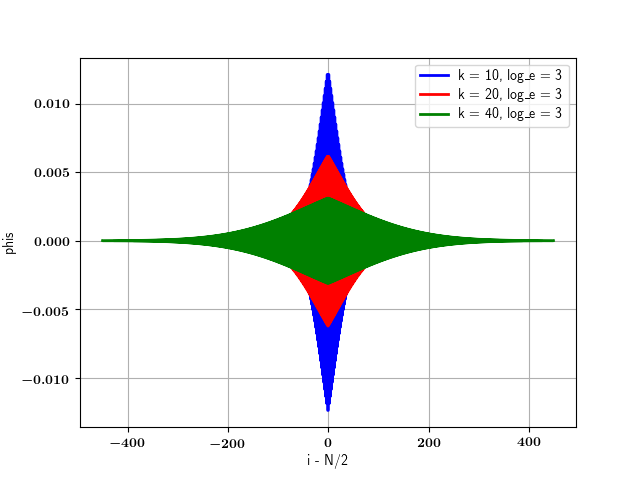

-1.5094948459637436e-05
-9.38555051188672e-06
4.630871480504339e-06

-1.5094948459637436e-05
-9.38555051188672e-06
4.630871480504339e-06

-0.01237717373510483
-0.0062193748575711805
-0.003117353883251184

-0.01237717373510483
-0.0062193748575711805
-0.003117353883251184


In [7]:
# -----------------------------------------
# --- Plot angles ----
# -----------------------------------------
fig = plt.figure()
ax = fig.add_subplot(111)
for ii in range(len(filenames_)): 
    Nphis = len(dds_[ii]["phis"]) 
    x_array = np.array(range(Nphis)) - Nphis/2
    ax.plot(
        x_array, 
        dds_[ii]["phis"] - np.pi/2., 
        color=colors_[ii], 
        linewidth = 2, linestyle='-',
#         marker = "o", 
        label = "k = {:d}, log_e = {:d}".format(
            int(dds_[ii]["function-parameter"]),
            -int(np.log10(dds_[ii]["abs-error"]))
        )
    )
plt.xlabel('i - N/2')
plt.ylabel("phis")
# plt.xlim(-5, 5)
ax.legend()
plt.grid(True)
plt.show()
del ii

for ii in range(len(filenames_)):
    print(dds_[ii]["phis"][0] - np.pi/2.)
    
print()
for ii in range(len(filenames_)):
    print(dds_[ii]["phis"][-1] - np.pi/2.)
    
print()
for ii in range(len(filenames_)):
    print(dds_[ii]["phis"][len(dds_[ii]["phis"])//2-1] - np.pi/2.)
    
print()
for ii in range(len(filenames_)):
    print(dds_[ii]["phis"][len(dds_[ii]["phis"])//2] - np.pi/2.)

kappa: 40


<IPython.core.display.Javascript object>


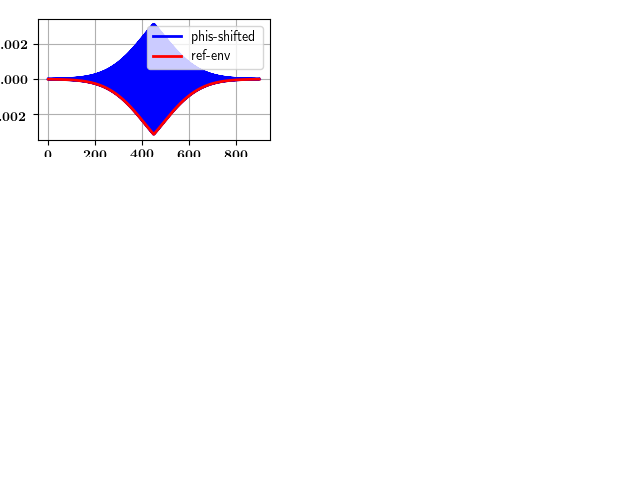

In [11]:
# ---------------------------------------------------
# --- Extract the envelop ---
# Amplitudes just oscillate between positive and negative values;
# Number of angles is linear with kappa;
# ---------------------------------------------------


# --- Choose the case ---
id_case = 2

# chosen QSVT angles
phis_ch    = dds_[id_case]["phis"]
range_full = np.array(range(len(phis_ch)))

# shifted QSVT angles:
phis_sh_ch = phis_ch - np.pi/2.

# chosen (shifted by pi/2) envelops:
peaks_ch   = extract_env(phis_sh_ch)

# chosen positive envelop: 
full_env_ref = peaks_ch["neg-v"];
max_v_ref = np.max(np.abs(full_env_ref))

# chosen indices of positive and negative envelop:
range_env_pos = peaks_ch["pos-i"]
range_env_neg = peaks_ch["neg-i"]

range_env_ref = range_env_neg

# chosen normalized positive envelop:
full_norm_env_ref = full_env_ref / max_v_ref
N_full_env = len(full_env_ref)

# chosen half envelop:
half_norm_env_ref  = full_norm_env_ref[0:N_full_env//2]; 
range_env_ref_half = range_env_ref[0:N_full_env//2] 
N_half_env         = len(range_env_ref_half)

# --- original envelops ---
print("kappa: {:0.0f}".format(dds_[id_case]["function-parameter"]))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range_full,    phis_sh_ch,        color="b", linewidth = 2, linestyle='-',  label = "phis-shifted")
ax.plot(range_env_ref, full_env_ref,      color="r", linewidth = 2, linestyle='-',  label = "ref-env")
ax.plot()
plt.xlabel('i')
plt.ylabel("env")
# plt.xlim(0, 5)
ax.legend()
plt.grid(True)
plt.show()



## -------------------------------------------------------------------
# --- With positive peaks ---
# --------------------------------------------------------------------
# # --- Choose the case ---
# id_case = 2

# # chosen QSVT angles
# phis_ch    = dds_[id_case]["phis"]
# range_full = np.array(range(len(phis_ch)))

# # shifted QSVT angles:
# phis_sh_ch = phis_ch - np.pi/2.

# # chosen (shifted by pi/2) envelops:
# peaks_ch   = extract_env(phis_sh_ch)

# # chosen positive envelop: 
# full_env_ref = peaks_ch["pos-v"];
# max_v_ref = np.max(full_env_ref)

# # chosen indices of positive and negative envelop:
# range_env_pos = peaks_ch["pos-i"]
# range_env_neg = peaks_ch["neg-i"]

# # chosen normalized positive envelop:
# full_norm_env_ref = full_env_ref / max_v_ref
# N_full_env = len(full_env_ref)

# # chosen half envelop:
# half_norm_env_ref  = full_norm_env_ref[0:N_full_env//2]; 
# range_env_pos_half = range_env_pos[0:N_full_env//2] 
# N_half_env         = len(range_env_pos_half)

# # --- original envelops ---
# print("kappa: {:0.0f}".format(dds_[id_case]["function-parameter"]))

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(range_env_pos, full_env_ref,      color="b", linewidth = 2, linestyle='-',  label = "pos-env")
# ax.plot(range_env_neg, peaks_ch["neg-v"], color="r", linewidth = 2, linestyle='--', label = "neg-env")
# ax.plot(range_full,    phis_sh_ch,        color="g", linewidth = 2, linestyle='-',  label = "phis-shifted")
# ax.plot()
# plt.xlabel('i')
# plt.ylabel("env")
# # plt.xlim(0, 5)
# ax.legend()
# plt.grid(True)
# plt.show()

In [12]:
# -----------------------------------------------------------------
# --- Functions for approximating the envelop ---
# -----------------------------------------------------------------
def test_func_x_pol(xx, aa):
    res_pol = 0.0
    for ii in range(Na):
        res_pol += aa[ii] * cp.power(xx, 2*ii)
    return res_pol


def np_test_func_x_pol(xx, aa):
    res_pol = np.zeros(Nx)
    res_pol = 0.0
    for ii in range(Na):
        res_pol += aa[ii] * np.power(xx, 2*ii)
    return res_pol


# -------------------------------------------------------
def test_func_even_Ch(x, a):
    res_pol = 0.
    for ii in range(Na):
        res_pol += a[ii] * np.cos((2*ii) * np.arccos(x))
    return res_pol


def np_test_func_even_Ch(x, a):
    Nx = len(x)
    res_pol = np.zeros(Nx)
    for ix in range(Nx):
        res_pol[ix] = 0.
        for ii in range(Na):
            res_pol[ix] += a[ii] * np.cos((2*ii) * np.arccos(x[ix]))
    return res_pol
# --------------------------------------------------------

# --- Choose the approximation parameters and functions ---
Na = 6
# test_func, np_test_func = test_func_x_pol, np_test_func_x_pol
test_func, np_test_func = test_func_even_Ch, np_test_func_even_Ch

<IPython.core.display.Javascript object>


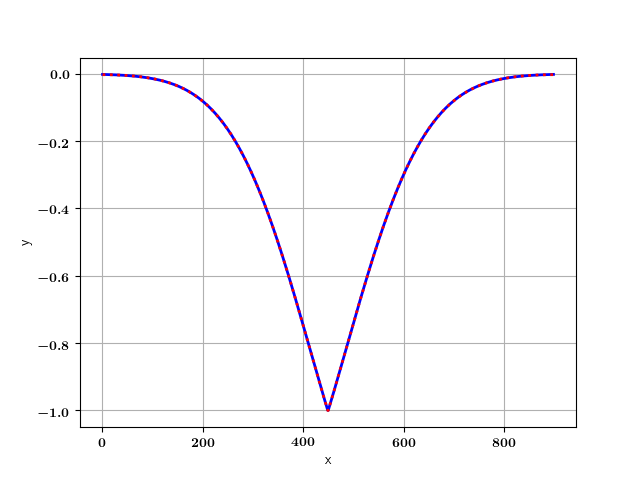


---------------------------
kappa: 40
absolute error: 8.135e-04
parameters: 
-4.360801e-01 -5.226961e-01 -6.770340e-02  2.464178e-02  2.474306e-03 -9.172489e-04 


In [13]:
# -----------------------------------------------------------------
# --- Approximate the envelop ---
# -----------------------------------------------------------------

# --- standard x-grid ---
x = np.linspace(0.0, 1.0, N_half_env)

# # --- x-grid: Chebyshev roots ---
# x = np.zeros(N_half_env)
# for ii in range(N_half_env):
#     x[ii] = np.cos((2*ii+1) * np.pi / (4.*N_half_env))

# --- Approximation ---
a = cp.Variable(Na)
objective = cp.Minimize(cp.sum_squares(test_func(x,a) - half_norm_env_ref))
prob = cp.Problem(objective)
result = prob.solve()

half_env_appr = np_test_func(x, a.value)
full_env_appr = np.concatenate((
    half_env_appr, np.flip(half_env_appr)
))

# --- Maximum absolute error ---
abs_err = np.max(np.abs(full_env_appr - full_norm_env_ref))

# # --- plot the half envelop ---
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(range_env_pos_half, half_norm_env_ref,  color="b", linewidth = 2, linestyle='-')
# ax.plot(range_env_pos_half, half_env_appr,      color="r", linewidth = 2, linestyle=':')
# plt.xlabel('x')
# plt.ylabel("y")
# # plt.xlim(-5, 5)
# plt.grid(True)
# plt.show()

# --- plot the full envelop ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range_env_ref, full_norm_env_ref,  color="b", linewidth = 2, linestyle='-')
ax.plot(range_env_ref, full_env_appr,      color="r", linewidth = 2, linestyle=':')
plt.xlabel('x')
plt.ylabel("y")
# plt.xlim(-5, 5)
plt.grid(True)
plt.show()

# --- Resulting parameters ---
print("\n---------------------------")
print("kappa: {:0.0f}".format(dds_[id_case]["function-parameter"]))
print("absolute error: {:0.3e}".format(abs_err))
print("parameters: ")
mix.print_array(a.value, ff=[13, 6, "e"])

In [18]:
half_env_appr[-1]

-1.0002807520723376

max-abs-err: 4.751e-06


<IPython.core.display.Javascript object>


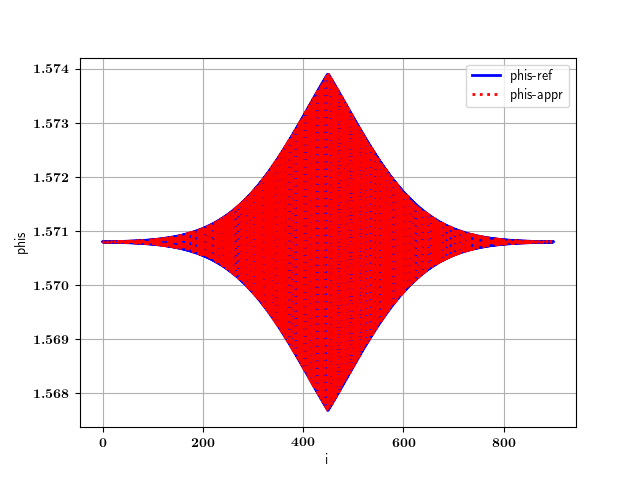

In [25]:
# -------------------------------------------------------------
# --- Reproduce QSVT angles ---
# -------------------------------------------------------------
phis_appr = np.zeros(len(range_full)//2)
Nh = len(phis_appr)
counter_el = -1
v1 = 0.0
for ii in range(N_half_env-1):
    v1 = half_env_appr[N_half_env - ii - 1]
    
    counter_el += 1
    phis_appr[Nh - counter_el - 1] = -v1
    
    counter_el += 1
    
    v2 = half_env_appr[N_half_env - ii - 2]
    phis_appr[Nh - counter_el - 1] = (v1+v2)/2.  
    
    
# add last negative value in the first half:   
if len(range_env_pos) != len(range_env_neg):
    counter_el += 1
    phis_appr[counter_el] = -v1   
else:
    phis_appr *= -1.0
del counter_el, v1, ii

phis_appr = np.concatenate(
    (phis_appr, np.flip(phis_appr))
)
    
phis_appr = max_v_ref * phis_appr + np.pi/2.

abs_err = np.max(np.abs(phis_ch - phis_appr))
print("max-abs-err: {:0.3e}".format(abs_err))

# --- plot angles ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range_full, phis_ch,   color="b", linewidth = 2, linestyle='-', label = "phis-ref")
ax.plot(range_full, phis_appr, color="r", linewidth = 2, linestyle=':', label = "phis-appr")
plt.xlabel('i')
plt.ylabel("phis")
# plt.xlim(-5, 5)
ax.legend()
plt.grid(True)
plt.show()

Na: 900


<IPython.core.display.Javascript object>


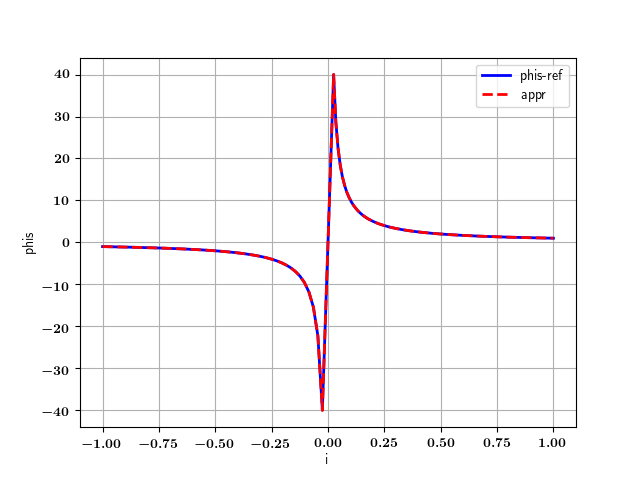

In [27]:
# -------------------------------------------------------
# --- Compute 1/x using a sequence of rotations ---
# -------------------------------------------------------

# compute the inverse function using the full set of QSVT angels:
def compute_inverse_function(x1):
    # - W-matrix -
    xs = 1j*np.sqrt(1 - x1**2)
    W = np.array([
        [x1, xs],
        [xs, x1]
    ], dtype = complex)

    # - sequence of rotations -
    U = np.array(Rphi[0])
    for ia in range(1,Na):
        U = U.dot(W).dot(Rphi[ia])
    return U[0,0].real


# -------------------------------------------------------
# QSVT angles for the matrix inversion:
phis_comp = np.array(phis_appr)
# phis_comp = np.array(dds_[id_case]["phis"])

Na = len(phis_comp)
print("Na: {:d}".format(Na))

kappa = dds_[id_case]["function-parameter"]

# corrections of the angles:
phis_comp     -= np.pi/2.
phis_comp[0]  += np.pi/4.
phis_comp[-1] += np.pi/4.

# x-grid:
Nx = 101
x_grid_1 = np.linspace(-1.0, -1.0/kappa)
x_grid_2 = np.linspace(1.0/kappa, 1.0, Nx)
x_grid = np.concatenate((x_grid_1, x_grid_2))
Nx = len(x_grid)

# rotation matrices:
Rphi = np.zeros((Na,2,2), dtype = complex)
for ia in range(Na):
    ephi = np.exp(1j * phis_comp[ia])
    Rphi[ia,0,0] = ephi
    Rphi[ia,1,1] = np.conjugate(ephi)

# odd parity:
inv_f = np.zeros(Nx)
for ix in range(Nx):
    inv_f[ix] = compute_inverse_function(x_grid[ix])
    
# --- the reference case ---
inv_ref = 1./x_grid

# --- Plotting the computed inverse function ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_grid, inv_ref, color="b", linewidth = 2, linestyle='-', label = "phis-ref")
ax.plot(x_grid, inv_f * kappa * 8,   color="r", linewidth = 2, linestyle='--', label = "appr")
plt.xlabel('i')
plt.ylabel("phis")
# plt.xlim(-5, 5)
ax.legend()
plt.grid(True)
plt.show()

In [25]:
print(compute_inverse_function(1.0))
print(compute_inverse_function(0.999))

-5.566606200151772e-16
0.0031331373821355504
